In [1]:
import os
import sys
# Allow this notebook to import local libraries 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from topic_modelling.preprocessor_all import load_data
from topic_modelling.pipelines import basic_pipeline, spacy_pipeline
from topic_modelling.preprocessor_all import load_data
from topic_modelling.models import BasicModel, HierarchicalModel, EnsembleModel, NMFModel

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

# Table of contents
* [1. Load and preprocess data](#1)
* [2. Modeling](#2)
    * [2.1 LDA Basic Mode](#2.1)
        * [2.1.1 Hyper-parameter Tuning](#2.1.1)
        * [2.1.2 Find best number of topics](#2.1.2)
        * [2.1.3 Grid Search](#2.1.3)
    * [2.2 NMF](#2.2)
    * [2.3 Ensemble](#2.3)
* [3. Topic Analysis](#3)
    * [3.1 LDA BoW Model](#3.1)
    * [3.2 LDA Tfidf Model](#3.2)
* [4. Model Selection and Analysis](#4)
    * [4.1 Model Selection](#4.1)
    * [4.2 Analysis and insights from topics](#4.2)


## 1. Load and preprocess data <a class="anchor" id="1"></a>

In [3]:
df = load_data()
df = spacy_pipeline.apply(df, column='cleanBody')

Func:load_data took: 0.52 seconds
Func:reset_index took: 0.01 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:demoji_preprocessor took: 19.72 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:tweet_preprocessor took: 1.20 seconds
:: Spacy preprocessor -> cleaning, this might take 1-2 minutes....


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:spacy_preprocessor took: 55.71 seconds


Pandas Apply:   0%|          | 0/42368 [00:00<?, ?it/s]

Func:predefined_denoiser took: 0.10 seconds
Func:drop_empty took: 0.02 seconds
Func:reset_index took: 0.01 seconds


Pandas Apply:   0%|          | 0/42360 [00:00<?, ?it/s]

Func:tokenizer_transformer took: 0.31 seconds


Pandas Apply:   0%|          | 0/42360 [00:00<?, ?it/s]

Func:ngrammer_2_3_pre_trained took: 0.29 seconds


# 2. Modeling<a class="anchor" id="2"></a>

## 2.1 LDA Basic Model<a class="anchor" id="2.1"></a>

In [4]:
basic_model = BasicModel()
basic_model.fit(df,'cleanBody')
basic_model.train(num_topics=6, 
                  passes=1,
                  chunksize=100,
                  eval_every=10,
                  alpha = 0.9,
                  decay=0.3,
                  tfidf = False
                 )

print(basic_model.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.22 seconds
Func:filter_extremes took: 0.02 seconds
Func:create_bow_coprpus took: 0.10 seconds
Func:create_tfidf_corpus took: 0.03 seconds
----> Training BasicModel <----
Func:train took: 3.73 seconds

Coherence Score:  0.5731948690935075
Func:get_coherance took: 2.64 seconds
0.5731948690935075


## 2.1 LDA Tfidf Model<a class="anchor" id="2.1"></a>

In [27]:
lda_tfidf_model = BasicModel()
lda_tfidf_model.fit(df,'cleanBody')
lda_tfidf_model.train(num_topics=7, 
                  passes=1,
                  chunksize=100,
                  eval_every=10,
                  alpha = 'symmetric',
                  decay=0.6,
                  tfidf = True
                 )

print(lda_tfidf_model.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.23 seconds
Func:filter_extremes took: 0.02 seconds
Func:create_bow_coprpus took: 0.11 seconds
Func:create_tfidf_corpus took: 0.03 seconds
----> Training BasicModel <----
Func:train took: 4.47 seconds

Coherence Score:  0.502185778315482
Func:get_coherance took: 2.74 seconds
0.502185778315482


### 2.1.1 Hyper-parameter Tuning<a class="anchor" id="2.1.1"></a>

### 2.1.2 Find best number of topics<a class="anchor" id="2.1.2"></a>

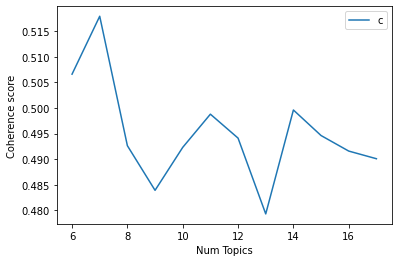

In [6]:
model_list, coherence_values = basic_model.compute_coherence_values(start=6, limit=18, step=1, plot=True)

In [7]:
for m,c in (zip(model_list, coherence_values)):
    print(f"Topics:{m.num_topics},Coherence score:{c}")

Topics:6,Coherence score:0.5066259359946337
Topics:7,Coherence score:0.51795216987792
Topics:8,Coherence score:0.4926395636643403
Topics:9,Coherence score:0.48391288257384246
Topics:10,Coherence score:0.49231141130199096
Topics:11,Coherence score:0.4988031722098475
Topics:12,Coherence score:0.49412231094784564
Topics:13,Coherence score:0.47930072947792984
Topics:14,Coherence score:0.499621466283475
Topics:15,Coherence score:0.4946250300588099
Topics:16,Coherence score:0.49158795446162795
Topics:17,Coherence score:0.49009198142034077


### 2.1.3 Grid Search<a class="anchor" id="2.1.3"></a>

In [8]:
import numpy as np
import tqdm
import gensim
import pandas as pd


def grid_search(df:pd.DataFrame,  k_start=5, k_end=12, k_step=1,
                alpha_start=0.2, alpha_end=1, alpha_step=0.2,
                decay_start=0.1, decay_end=0.5, decay_step=0.1
               )-> pd.DataFrame:

    """
    Create several models using different ranges for Alpha, Betta and Number of topics
    Part of the code was retrieved from : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
    """

    grid = {}

    # Topics
    topics_range = range(k_start, k_end, k_step)
    # ALPHA
    alpha_range = list(np.arange(alpha_start, alpha_end, alpha_step)) 
    alpha_range.append('symmetric')
    alpha_range.append('asymmetric')
    # Decay
    decay_range = list(np.arange(decay_start, decay_end, decay_step))
    
    chunksize_range = [100,300,500]
    passes_range = [1]
    model_results = {
                     'Topics': [],
                     'Alpha': [],
                     'Decay': [],
                     'Chunksize': [],
                     'Passes': [],
                     'Coherence': []
                    }

    total_combinations = len(topics_range)*len(alpha_range)*len(decay_range)*len(chunksize_range)*len(passes_range)
    print(f"Total Models to grid search: {total_combinations}")

    with tqdm.tqdm(total=total_combinations)as pbar:

        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha_range:
                # iterare through decay values
                for d in decay_range:
                    # iterare through chunk sizes
                    for c in chunksize_range:
                        # iterare through chunk sizes
                        for p in passes_range:
                            # get the coherence score for the given parameters
                            cv = basic_model.compute_coherence_for_topics_a_d(k=k, a=a, d=d, c=c, p=p, tfidf=True)
                            # Save the model results
                            model_results['Topics'].append(k)
                            model_results['Alpha'].append(a)
                            model_results['Decay'].append(d)
                            model_results['Chunksize'].append(c)
                            model_results['Passes'].append(p)
                            model_results['Coherence'].append(cv)
                            pbar.update(1)

        grid_search_results = pd.DataFrame(model_results).to_csv('gridSearch_results2.csv', index=False)
        pbar.close()
    
    return grid_search_results




### Run grid search 

In [9]:
# grid_search_results = grid_search(
#     df.cleanBody.to_list(),
#     k_start=4, k_end=8, k_step=1,
#     alpha_start=0.5, alpha_end=1, alpha_step=0.1,
#     decay_start=0.1, decay_end=0.3, decay_step=0.1,
# )

### Load Previous Grid Search results

### Bow LDA gridsearch

In [10]:
grid_search_results = pd.read_csv('gridSearch_results.csv')
grid_search_results.sort_values(by='Coherence', ascending= False).head(5)

,Topics,Alpha,Decay,Chunksize,Passes,Coherence
900,9,0.61,0.3,1500,1,0.597776
675,8,0.9099999999999999,0.3,1500,1,0.597586
1440,11,0.61,0.3,1500,1,0.597038
1170,10,0.61,0.3,1500,1,0.595427
945,9,0.9099999999999999,0.3,1500,1,0.594083


### TFIDF LDA gridsearch

In [11]:
grid_search_results = pd.read_csv('gridSearch_results2.csv')
grid_search_results.sort_values(by='Coherence', ascending= False).head(10)

,Topics,Alpha,Decay,Chunksize,Passes,Coherence
24,4,0.8999999999999999,0.1,100,1,0.586891
98,6,0.7,0.1,500,1,0.585723
14,4,0.7,0.1,500,1,0.582723
104,6,0.7999999999999999,0.1,500,1,0.582262
102,6,0.7999999999999999,0.1,100,1,0.581297
62,5,0.7999999999999999,0.1,500,1,0.573272
50,5,0.6,0.1,500,1,0.569391
68,5,0.8999999999999999,0.1,500,1,0.568744
108,6,0.8999999999999999,0.1,100,1,0.567316
110,6,0.8999999999999999,0.1,500,1,0.564067


### 2.1.4 Hierarchical Dirichlet Process<a class="anchor" id="2.1.4"></a>

In [12]:
hdpModel = HierarchicalModel()
hdpModel.fit(df,'cleanBody')
hdpModel.train()

print(hdpModel.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.22 seconds
Func:create_bow_coprpus took: 0.11 seconds
----> Training HierarchicalModel <----
Func:train took: 21.27 seconds

Coherence Score:  0.43463640001687165
Func:get_coherance took: 3.83 seconds
0.43463640001687165


In [13]:
print(hdpModel.model.show_topics(num_topics=8, formatted=True))

[(0, '0.080*travel + 0.070*san_diego + 0.069*usa + 0.052*condo + 0.052*vacation_rental + 0.052*mission_beach + 0.018*beach + 0.017*found_mission + 0.017*nice_vacation + 0.017*rental_condo + 0.001*holiday + 0.001*blog + 0.001*rent + 0.001*related_project + 0.001*feature + 0.001*palm_springs + 0.001*love + 0.001*condo_steps + 0.001*diego + 0.001*beach_condominiums'), (1, '0.035*travel + 0.018*love_dragonfly + 0.018*pool_houses + 0.018*rent_pioneertown + 0.018*desert_retreat + 0.003*san_diego + 0.002*usa + 0.002*holiday + 0.002*beach + 0.001*reet_ennet + 0.001*rental_condo + 0.001*jerusalem + 0.001*photography_helena + 0.001*found_mission + 0.001*nice_vacation + 0.001*travelpics_travelblogger + 0.001*touri + 0.001*beautiful_israel + 0.001*rent + 0.001*palm_springs'), (2, '0.036*travel + 0.013*bed_breakfasts + 0.013*owl_house + 0.013*rent_hightown + 0.013*guest_room + 0.003*san_diego + 0.003*usa + 0.002*beach + 0.002*holiday + 0.002*jerusalem + 0.002*travelpics_travelblogger + 0.002*photog

In [22]:
import pandas as pd

def topic_prob_extractor(gensim_hdp):
    shown_topics = gensim_hdp.show_topics(num_topics=8, num_words=10, formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

topic_prob_extractor(hdpModel.model)

,topic_id,weight
0,0,0.443478
1,1,0.117316
2,2,0.100086
3,3,0.117684
4,4,0.094194
5,5,0.079890
6,6,0.078604
7,7,0.065139


/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  fro

In [15]:
import warnings
warnings.filterwarnings('ignore')

## 2.2 NMF<a class="anchor" id="2.2"></a>


In [16]:
nmf_model = NMFModel()
nmf_model.fit(df, 'cleanBody')
nmf_model.train(num_topics=10)

print(nmf_model.get_topics())
print(nmf_model.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.22 seconds
Func:filter_extremes took: 0.02 seconds
Func:create_bow_coprpus took: 0.10 seconds
----> Training NMFModel <----
Func:train took: 35.31 seconds
------ Topic 0 ------
san_diego usa condo vacation_rental mission_beach beach condo_steps beach_condominiums diego cozy_san

------ Topic 1 ------
jerusalem reet_ennet photography_helena travelpics_travelblogger touri beautiful_israel wonderful_israel tour ttot visit

------ Topic 2 ------
christmas gift holiday_season winter lp days holidays xmas santa time

------ Topic 3 ------
palm_springs love rent mid_century modern_houses diego condo_steps beach_condominiums cozy_san beach

------ Topic 4 ------
beach found_mission nice_vacation rental_condo san_diego usa condo_steps cozy_san diego beach_condominiums

------ Topic 5 ------
holiday gifts party shopping fun check vacation family gift trip

------ Topic 6 ------
diego condo_steps beach_condominiums cozy_san rent beac

## 2.3 Ensemble<a class="anchor" id="2.3"></a>
https://radimrehurek.com/gensim/models/ensemblelda.html

In [17]:
ensemble_model = EnsembleModel()
ensemble_model.fit(df, 'cleanBody')
ensemble_model.train(num_topics=10, num_models=10)

print(ensemble_model.get_topics())
print(ensemble_model.get_coherance())

:: Size of id2word: 25387
Func:createid2word_dictionary took: 0.21 seconds
Func:filter_extremes took: 0.02 seconds
Func:create_bow_coprpus took: 0.11 seconds
----> Training EnsembleModel <----
Func:train took: 82.28 seconds
------ Topic 0 ------
photography_helena reet_ennet travelpics_travelblogger beautiful_israel jerusalem touri wonderful_israel tour san_diego usa

------ Topic 1 ------
bed_breakfasts owl_house guest_room rent_hightown contact events_influencermarketing yacht_cruise cover_beauty fashion_food tulipsinholland_spring

------ Topic 2 ------
palm_springs love rent mid_century modern_houses usa holiday japan_japantravel san_diego vacation_rental

None

Coherence Score:  0.446511638611854
Func:get_coherance took: 2.62 seconds
0.446511638611854


# 3. Topic Analysis<a class="anchor" id="3"></a>


## 3.1 LDA BoW Model<a class="anchor" id="3.1"></a>


In [18]:
vis = gensimvis.prepare(topic_model=basic_model.model, corpus=basic_model.corpus, dictionary=basic_model.id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## 3.2 LDA Tfidf Model<a class="anchor" id="3.2"></a>

In [28]:
vis = gensimvis.prepare(topic_model=lda_tfidf_model.model, corpus=lda_tfidf_model.corpus_tfidf, dictionary=basic_model.id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/twitter/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  fro

# 4. Model Selection and Analysis



## 4.1 Model Selection<a class="anchor" id="4.1"></a>

## Bow vs TF-IDF
Based on the grid-search values, we can identify the <b>Bow</b> model has slightly higher scores than the <b>IDF</b> model. In addition, the highest coherance score in bow gird search shows that the best number of topics is between 8-11 in comparison to <b>IDF</b> where the topics are between 4-6.


### Is coherance a good evaluation metric?
It's the best metric to get an understanding if your model is performing well. However, it can not always be trusted 100%.
Taking the example above, the <b>Bow</b> clusters are not coherant at all. 
* Many words appear in all clusters (i.e. San Diego, USA, vacation holiday etc.)
* By examining the words in the clusters, you can't get a unique topic out of them. Most of them are a mixture of different topics

Compared to the <b>IDF</b> model:
* We still have some topics that overlap
* But we can clearly see that we have distinct clusters now, by identifying the clusters being scattered accross the axis of the plot
* Most of our words have been grouped to one cluster
* Words under Topics make more sence

In [20]:
# lda_tfidf_model.freeze_model("lda_tfidf")

In [21]:
tokenized_text = [['paris', 'holiday', 'condo']]
tokenized_text = [['apoel', 'thrillos', 'afko']]


vector = [lda_tfidf_model.id2word.doc2bow(text) for text in tokenized_text]
topics = sorted(lda_tfidf_model.model[vector][0], key=lambda x: x[1], reverse=True)
print(topics)

[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]


## 4.2 Analysis and insights from topics<a class="anchor" id="4.2"></a>



### Business insights that can be drawn from this dataset
From the IDF model we can clearly see 2 unique clusters and another cluster which consists of many sub-clusters. 

### 3 big clusters

### 1. San Diego, beach resorts
* Users talk about USA and San Diego more specifically. 
* Users also seem to be intrested in renting condos near the beach 
* They also show interest in marine life, so maybe recommendig some bundle offers on condos and marine life adventure activities might be beneficial

### 2. International destinations
* Users are interested on holidays and familty travel on different destinations such as Japan and Italy (Vatican and Rome), Pioneertown even in some deserty destination
* Also it appears to be a trent with photography of some sort, are interested in:
    * The Nikon Camera
    * City reflexion
    * Dragon Flies
* Also they seems to be intrested in different types of accomodation and renting such as:
    * Renting in Hightown
    * Owl house
    * Pool houses
    * Guest rooms
    * Bed and breakfast


### 3. Mutliple overlapping Clusters 
All of those clusters seems to have 2 things in common:
1. International travelling
2. Photography

If we examine each cluster one by one we can identify the following:
* Israeel/Jerusalim for camping using RVS
* Holiday Destinations, maybe on Christmass at Italy and Argentina
* Another distinct cluster for Palm Strings. This topic seems to be for more outgoing people who enjoy partying, modern houses and luxary
* Another cluster maybe for couples or more romantic/cultural peaple. Popular destinations for this cluster is Pocasset and maybe California as well. They seems to be into wine and photography. Also they are intrested in
    * lighthouse rents
    * love wings
    * Chalet
    

